# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [16]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [17]:
today = datetime.datetime.now() - datetime.timedelta(0)
# tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 8, 14, 25, 7, 680029)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [18]:
with open('../data/keys/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="ML_Project_Electricity", api_key_value=os.environ["HOPSWORKS_API_KEY"])
fs = project.get_feature_store() 

2025-01-08 14:25:07,690 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 14:25:07,744 INFO: Initializing external client
2025-01-08 14:25:07,751 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 14:25:09,543 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207495


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [19]:
feature_view_se3 = fs.get_feature_view(
    name='se3_price_fv',
    version=1,
)

feature_view_se4 = fs.get_feature_view(
    name='se4_price_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [20]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="electricity_price_xgboost_model_new",
    version=1,
)


# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [21]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.0370556E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'int', 'float', 'int',
                            'int', 'int', 'float', 'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [22]:
sthlm_weather_fg = fs.get_feature_group(
    name='stockholm_weather',
    version=1,
)

malmo_weather_fg = fs.get_feature_group(
    name='malmo_weather',
    version=1,
)

sthlm_weather_data = sthlm_weather_fg.filter(sthlm_weather_fg.date >= today).read()
malmo_weather_data = malmo_weather_fg.filter(malmo_weather_fg.date >= today).read()

# Ensure the 'date' column is in datetime format
sthlm_weather_data['date'] = pd.to_datetime(sthlm_weather_data['date'])
malmo_weather_data['date'] = pd.to_datetime(malmo_weather_data['date'])

# Sort the weather data by the 'date' column
sthlm_weather_data.sort_values(by='date', inplace=True)
malmo_weather_data.sort_values(by='date', inplace=True)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


In [23]:
# skip the feature view and simply get the last available rolling mean from the price feature group
se3_price_fg = fs.get_feature_group(
    name='se3_electricity_prices',
    version=1,
)

se4_price_fg = fs.get_feature_group(
    name='se4_electricity_prices',
    version=1,
)

se3_price_data = se3_price_fg.read()
se4_price_data = se4_price_fg.read()

# Ensure the 'time' column is in datetime format
se3_price_data['time'] = pd.to_datetime(se3_price_data['time'])
se4_price_data['time'] = pd.to_datetime(se4_price_data['time'])

# Sort the price data by the 'time' column
se3_price_data.sort_values(by='time', inplace=True)
se4_price_data.sort_values(by='time', inplace=True)

se3_price_data.tail()

# get the last available rolling mean from the price feature group
se3_last_rolling_mean = se3_price_data['spot_price_rolling'].iloc[-1]
se4_last_rolling_mean = se4_price_data['spot_price_rolling'].iloc[-1]


# se3_last_rolling_mean

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


In [24]:
se3_price_data.tail()

,time,pricearea,spotpriceeur,spot_price_rolling,spot_price_rolling_3h
17545,2025-01-09 18:00:00+00:00,SE3,127.59,22.614167,134.183333
17547,2025-01-09 19:00:00+00:00,SE3,119.99,23.247917,128.956667
17563,2025-01-09 20:00:00+00:00,SE3,102.52,23.808036,116.700000
17561,2025-01-09 21:00:00+00:00,SE3,97.85,24.362738,106.786667
17556,2025-01-09 22:00:00+00:00,SE3,68.53,24.746369,89.633333


In [25]:
# Add the last available rolling mean to the weather data

sthlm_weather_data['spot_price_rolling'] = se3_last_rolling_mean
malmo_weather_data['spot_price_rolling'] = se4_last_rolling_mean

In [26]:
# Combine the weather data into one dataframe with a feature for region, 0 for Stockholm and 1 for Malmo

# Add a column for the region
sthlm_weather_data['region'] = 0
malmo_weather_data['region'] = 1

# Combine the weather data
weather_data = pd.concat([sthlm_weather_data, malmo_weather_data], axis=0)

In [27]:
features = weather_data.drop(columns=['date', 'time'])

# Rearrange the columns to match the expected feature names
expected_feature_names = ['spot_price_rolling', 'temperature', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'weekday', 'month', 'hour', 'sunshine_duration', 'region']
features = features[expected_feature_names]

# Make predictions using the retrieved XGBoost regressor model
predictions = retrieved_xgboost_model.predict(features)

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame({
    'time': weather_data['time'],
    'predicted_price': predictions,
    'region': weather_data['region']
})


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

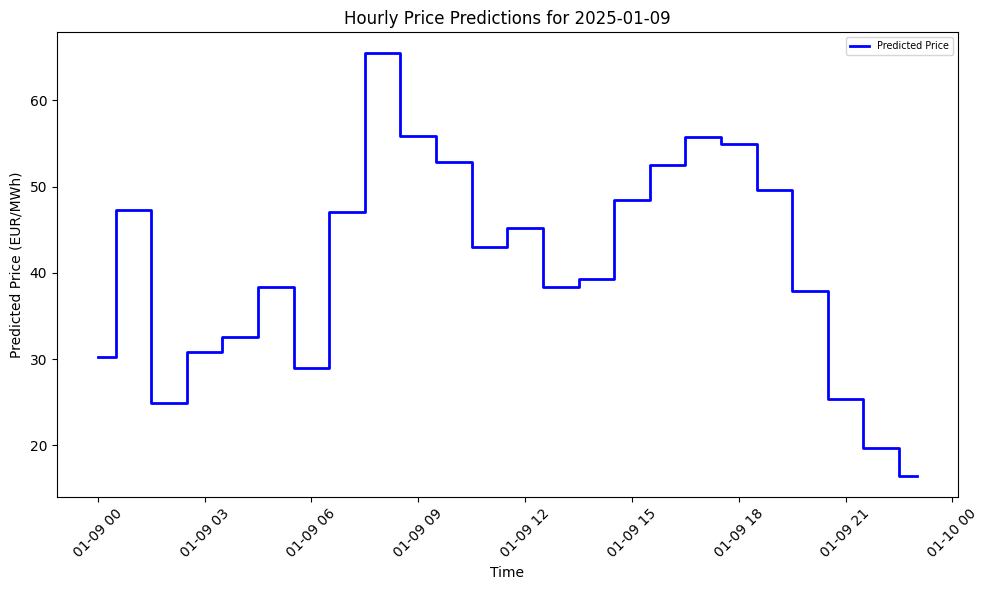

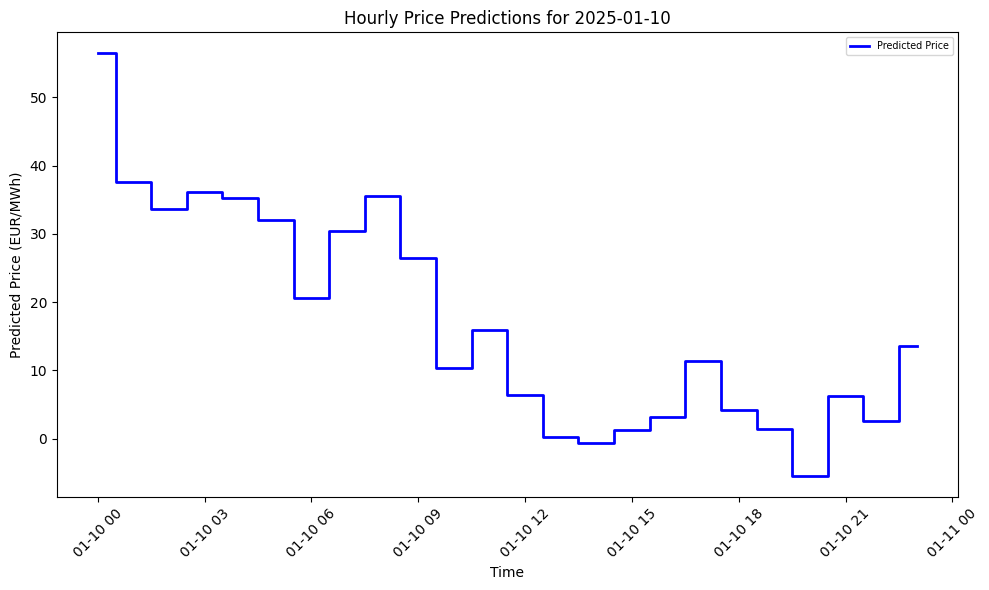

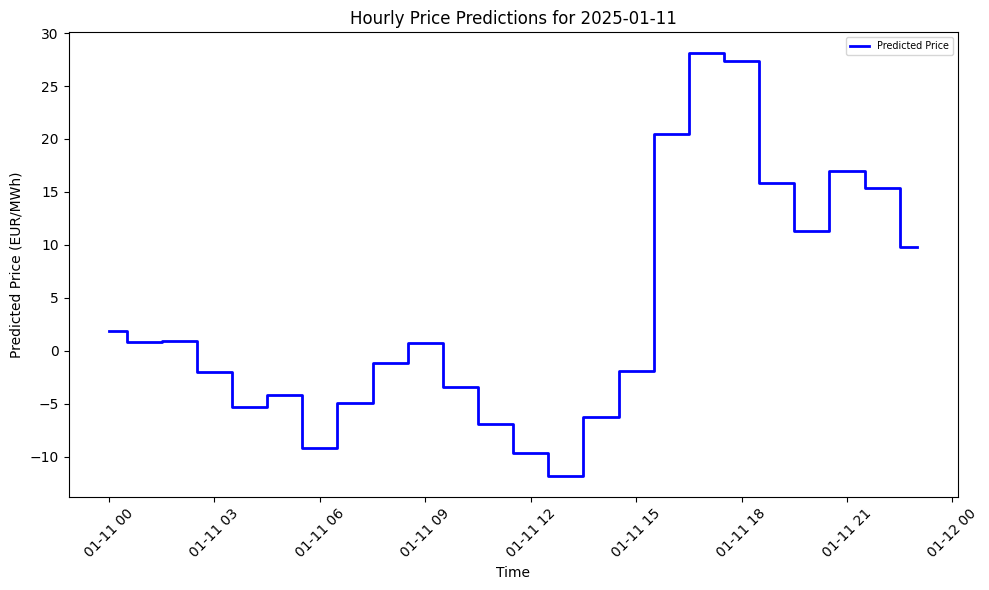

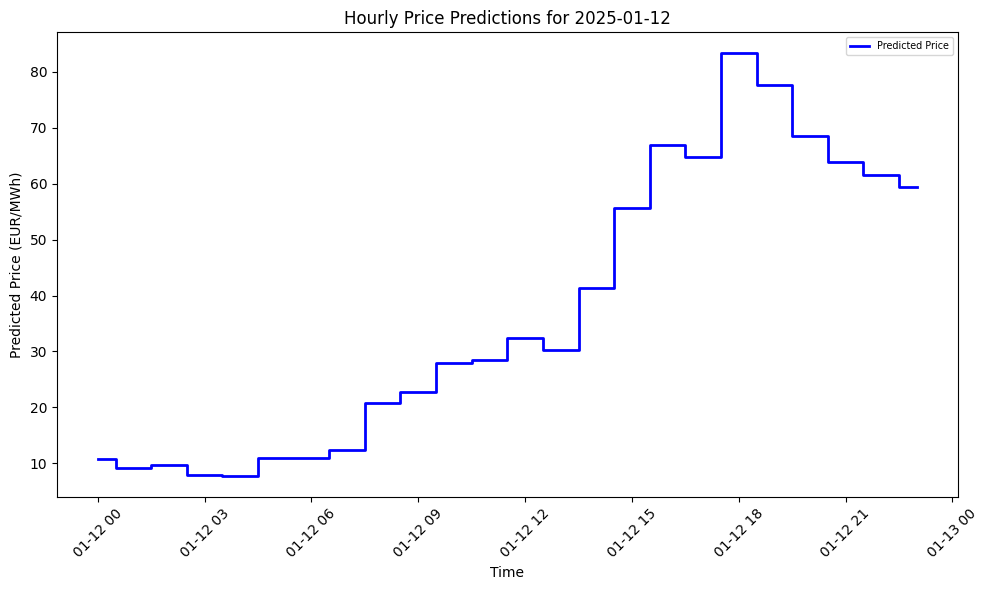

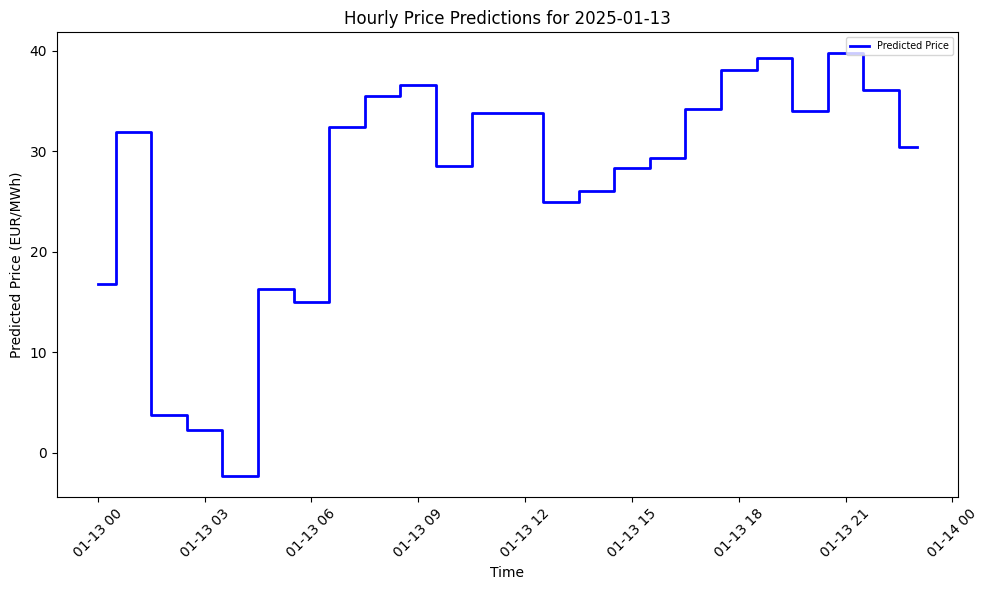

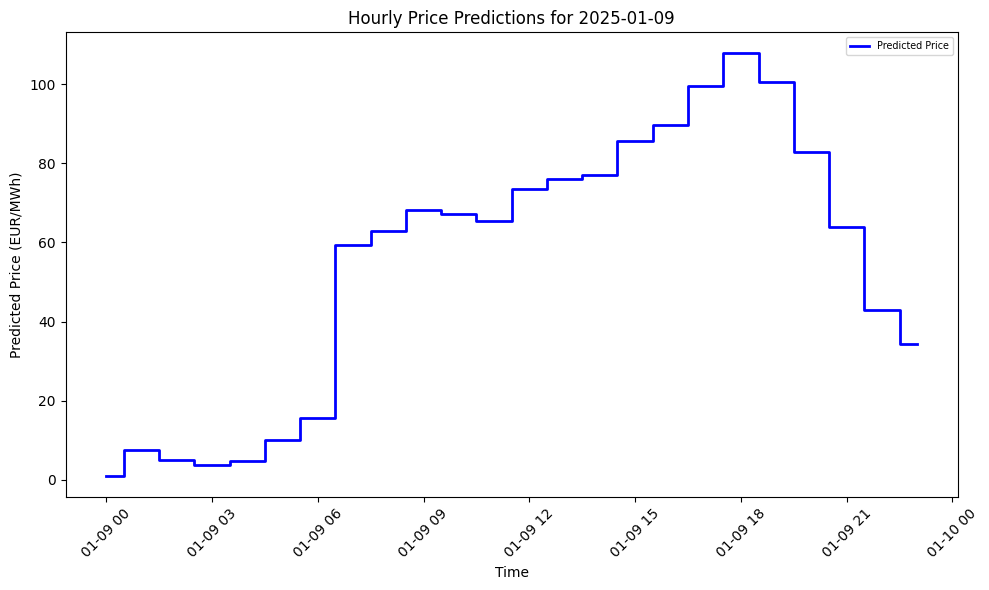

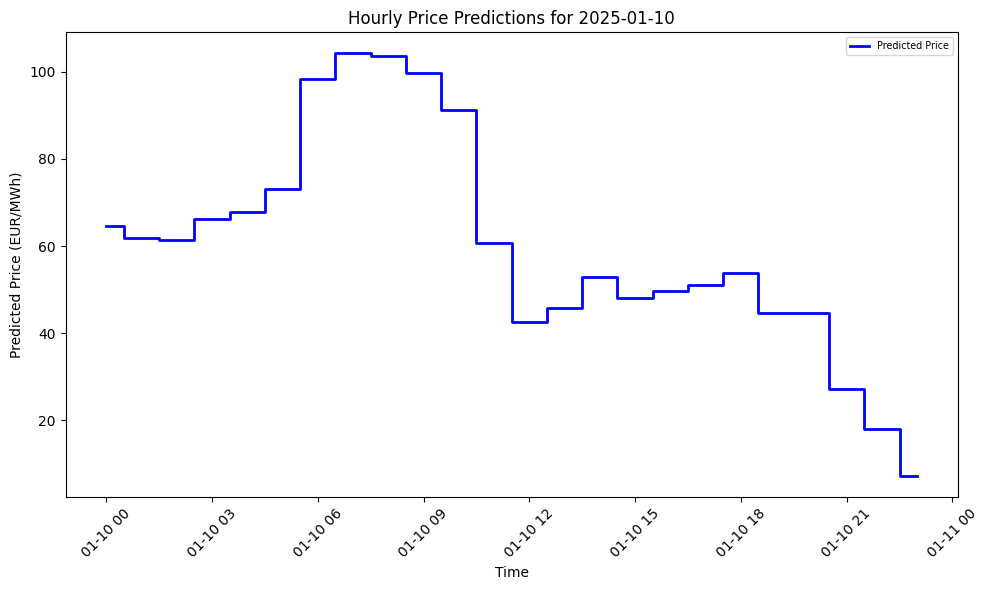

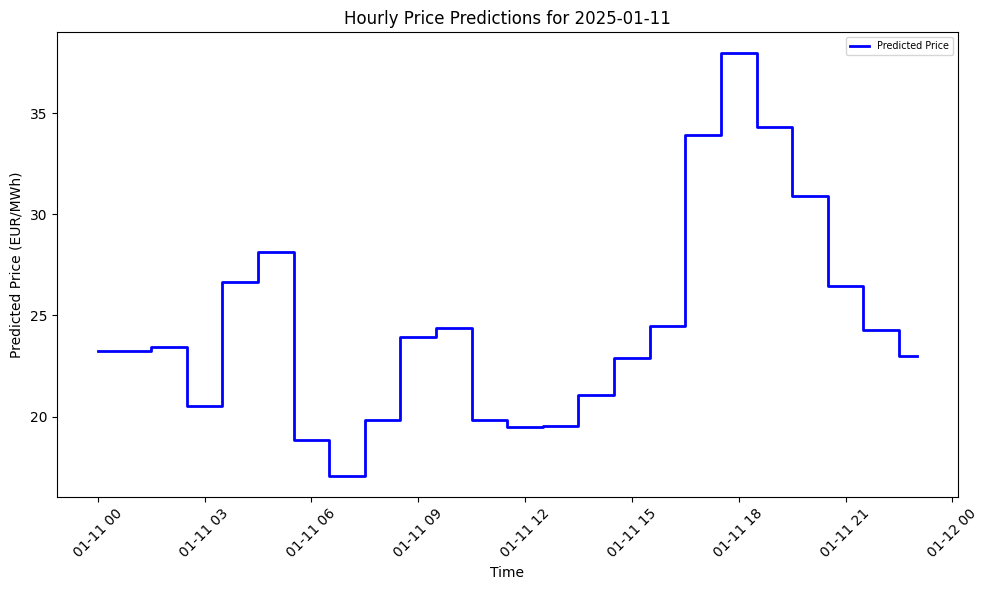

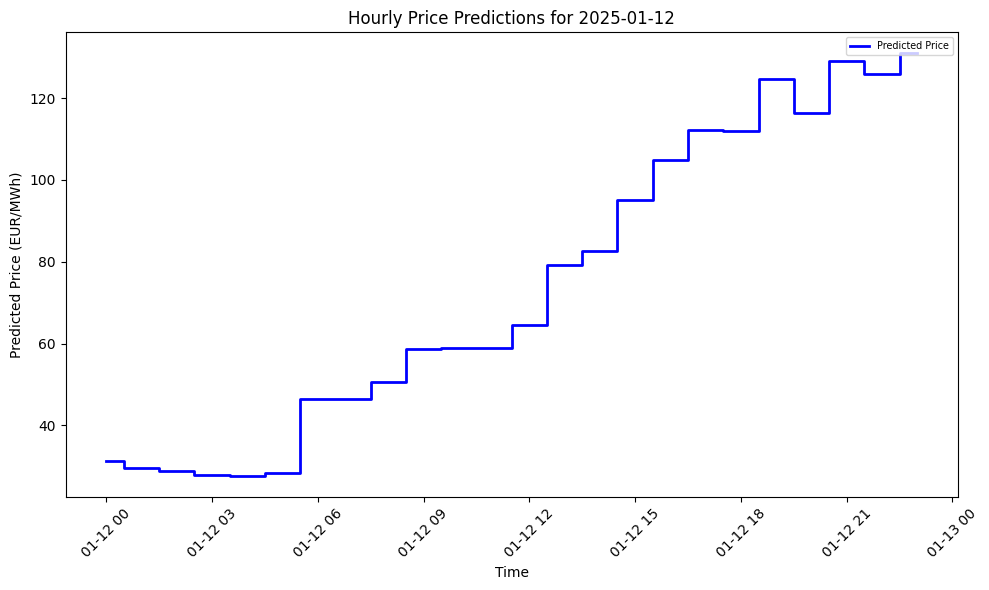

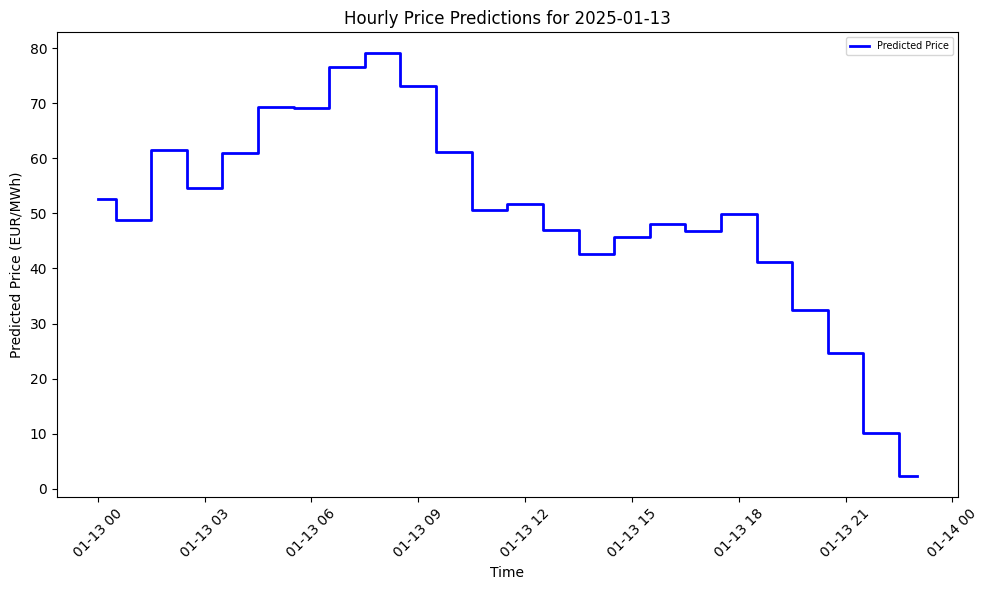

In [28]:
# For each date in the predictions DataFrame, create a separate plot and save it in the plots folder

# Split into separate dataframes based on the region
predictions_df_se3 = predictions_df.loc[predictions_df['region'] == 0].copy()
predictions_df_se4 = predictions_df.loc[predictions_df['region'] == 1].copy()

for i, date in enumerate(predictions_df['time'].dt.date.unique()):
    file_path = f"../docs/plots/hourly_price_predictions_se3_{i}.png"
    plt = util.plot_hourly_price_predictions(predictions_df_se3, str(date), file_path)
    plt.show()

for i, date in enumerate(predictions_df['time'].dt.date.unique()):
    file_path = f"../docs/plots/hourly_price_predictions_se4_{i}.png"
    plt = util.plot_hourly_price_predictions(predictions_df_se4, str(date), file_path)
    plt.show()


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [29]:
# weather_data['street'] = street
# weather_data['city'] = city
# weather_data['country'] = country
# # Fill in the number of days before the date on which you made the forecast (base_date)
# weather_data['days_before_forecast_day'] = range(1, len(weather_data)+1)
# # weather_data = weather_data.sort_values(by=['date'])
# weather_data

In [30]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 79
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   date                240 non-null    datetime64[ns, Etc/UTC]
 1   time                240 non-null    datetime64[ns, Etc/UTC]
 2   temperature         240 non-null    float64                
 3   precipitation       240 non-null    float64                
 4   cloud_cover         240 non-null    int64                  
 5   wind_speed_10m      240 non-null    float64                
 6   weekday             240 non-null    int64                  
 7   month               240 non-null    int64                  
 8   hour                240 non-null    int64                  
 9   sunshine_duration   240 non-null    float64                
 10  spot_price_rolling  240 non-null    float64                
 11  region              240 non-null    int64     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [31]:
# file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
# plt = util.plot_air_quality_forecast(city, street, weather_data, file_path)
# plt.show()

In [32]:
# # Get or create feature group
# monitor_fg = fs.get_or_create_feature_group(
#     name='aq_predictions_new',
#     description='Air Quality prediction monitoring',
#     version=1,
#     primary_key=['city','street','date','days_before_forecast_day'],
#     event_time="date"
# )

In [33]:
# monitor_fg.insert(weather_data, write_options={"wait_for_job": True})

In [34]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

NameError: name 'monitor_fg' is not defined

In [ ]:
# air_quality_fg = fs.get_feature_group(
#     name='air_quality_new',
#     version=1,
# )
# air_quality_df = air_quality_fg.read()
# air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 


,date,pm25,rolling_mean_pm25,country,city,street,url
0,2015-09-14 00:00:00+00:00,21.0,17.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
1,2019-02-27 00:00:00+00:00,55.0,41.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
2,2021-04-06 00:00:00+00:00,59.0,60.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3,2023-10-13 00:00:00+00:00,34.0,35.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
4,2016-05-01 00:00:00+00:00,27.0,34.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
...,...,...,...,...,...,...,...
3364,2020-12-08 00:00:00+00:00,57.0,49.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3365,2020-09-10 00:00:00+00:00,35.0,31.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3366,2021-04-30 00:00:00+00:00,26.0,43.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3367,2024-11-14 00:00:00+00:00,52.0,52.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638


In [ ]:
# outcome_df = air_quality_df[['date', 'pm25']]
# preds_df =  monitoring_df[['date', 'predicted_pm25']]

# hindcast_df = pd.merge(preds_df, outcome_df, on="date")
# hindcast_df = hindcast_df.sort_values(by=['date'])


# # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# if len(hindcast_df) == 0:
#     pass
#     # hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
# hindcast_df

,date,predicted_pm25,pm25
0,2024-11-15 00:00:00+00:00,48.371498,32.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

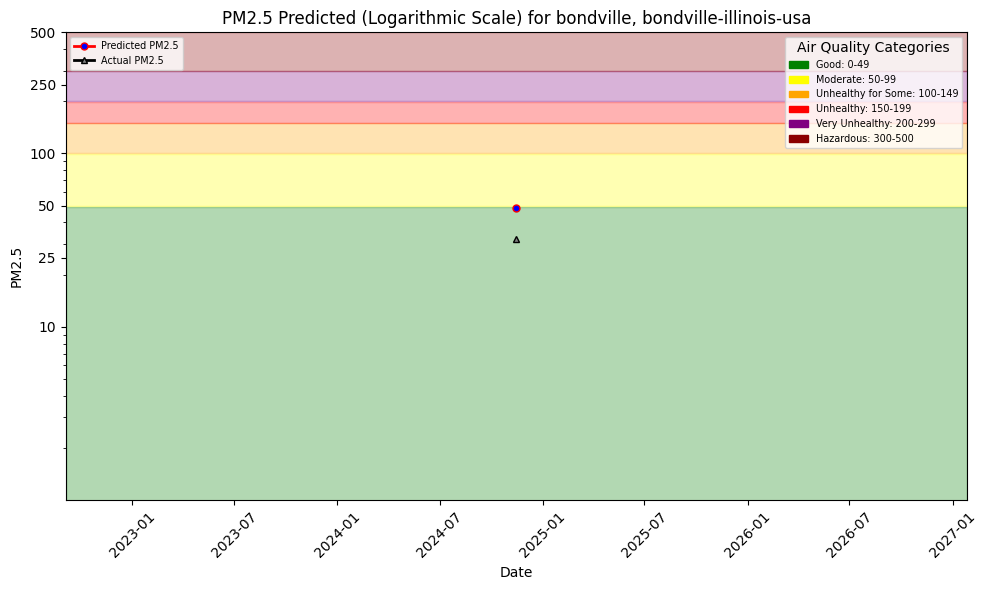

In [ ]:
# file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
# plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
# plt.show()

---